Introduction: We are trying create a model which predicts the crub-weight of an automobile(Weight of car including the full tank).

Steps we are following
1. Loading data
2. Cleaning data
3. EDA
4. Feature selection
5. Normalizing the data
6. Train the model with 2 regressions (Linear & Ridge)
7. Adding Cross Validation step.

In [1]:
### Import packages

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os

### sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

###### Standardization of the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#### Modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold

# Loading Data

In [2]:
### load data from csv via github url

colnames=['symboling','normalized-losses','make',' fuel-type','aspiration','num-of-doors','body-style','drive-wheels',
         'engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders',
         'engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg',
         'highway-mpg','price']

github_url = 'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/M2%20Practical%20Challenge%20Cross%20Validating%20a%20Linear%20Regression%20Model/M2_Data.csv'

automobile_df = pd.read_csv(github_url, names=colnames, header=None)
automobile_df.head(2)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500


# Data Cleaning

In [3]:
### As mentioned in assignment we are filtering only few columns for this assignment & dropping duplicates in same step

automobile_df = automobile_df[['height','width','length','wheel-base','engine-size','horsepower','peak-rpm',
                              'city-mpg','curb-weight']]

print("No of duplicate rows: ",automobile_df.duplicated().sum())

automobile_df = automobile_df.drop_duplicates().reset_index(drop=True)

print("No of duplicate rows after dropping duplicates: ",automobile_df.duplicated().sum())

automobile_df.head(2)

No of duplicate rows:  14
No of duplicate rows after dropping duplicates:  0


,height,width,length,wheel-base,engine-size,horsepower,peak-rpm,city-mpg,curb-weight
0,48.8,64.1,168.8,88.6,130,111,5000,21,2548
1,52.4,65.5,171.2,94.5,152,154,5000,19,2823


Description of columns used

1. height, width, length: Dimensions of the automobile
2. wheel-base: distance between front wheel & rear wheel
3. engine-size: size of the engine
4. horsepower: power of engine produces
5. peak-rpm: peak-rotations per minute (how fast the engine is spinnning)
6. city-mpg: on city conditions (avg miles per gallon)
7. curb-weight: weight of vehicle with all equipment & full tank fuel. 

In [4]:
automobile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   height       191 non-null    float64
 1   width        191 non-null    float64
 2   length       191 non-null    float64
 3   wheel-base   191 non-null    float64
 4   engine-size  191 non-null    int64  
 5   horsepower   191 non-null    object 
 6   peak-rpm     191 non-null    object 
 7   city-mpg     191 non-null    int64  
 8   curb-weight  191 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 13.6+ KB


No null values in dataset so no need to worry about nulls, but we need to change datatypes from object to float

In [5]:
### Checking why float is object with value_counts()

automobile_df['horsepower'].value_counts()

68     17
69     10
70     10
110     8
116     8
114     6
160     6
95      6
62      6
76      5
97      5
82      5
88      5
145     5
86      4
123     4
101     4
102     4
92      4
73      3
84      3
111     3
90      3
85      3
182     3
121     3
152     3
112     2
56      2
161     2
94      2
156     2
52      2
?       2
207     2
162     2
155     2
184     2
100     2
55      1
262     1
134     1
115     1
140     1
48      1
58      1
60      1
78      1
176     1
135     1
200     1
64      1
120     1
72      1
154     1
288     1
143     1
142     1
175     1
106     1
Name: horsepower, dtype: int64

In [6]:
# Percentage '?' in each column (as we found ? in horsepower column)

question_mark_count = automobile_df.apply(lambda x: x.astype(str).str.count('\?').sum())

round(question_mark_count / len(automobile_df) * 100,2)

height         0.00
width          0.00
length         0.00
wheel-base     0.00
engine-size    0.00
horsepower     1.05
peak-rpm       1.05
city-mpg       0.00
curb-weight    0.00
dtype: float64

In [7]:
### as we have 1 - 1.5 % of these values we will remove them

# Filter rows where any column contains '?'
automobile_df = automobile_df[~automobile_df.apply(lambda x: x.astype(str).str.contains('\?')).any(axis=1)]

# Percentage '?' in each column (as we found ? in horsepower column)
question_mark_count = automobile_df.apply(lambda x: x.astype(str).str.count('\?').sum())

print("Post removing ? ")
round(question_mark_count / len(automobile_df) * 100,2)

Post removing ? 


height         0.0
width          0.0
length         0.0
wheel-base     0.0
engine-size    0.0
horsepower     0.0
peak-rpm       0.0
city-mpg       0.0
curb-weight    0.0
dtype: float64

In [8]:
### Creating function for changing datatypes

def Object2Float(data,colnames):
    
    data[colnames] = data[colnames].astype(float)
    
    return data

In [9]:
## Calling function
colnames = ['horsepower','peak-rpm']
automobile_df = Object2Float(automobile_df,colnames)

automobile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 0 to 190
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   height       189 non-null    float64
 1   width        189 non-null    float64
 2   length       189 non-null    float64
 3   wheel-base   189 non-null    float64
 4   engine-size  189 non-null    int64  
 5   horsepower   189 non-null    float64
 6   peak-rpm     189 non-null    float64
 7   city-mpg     189 non-null    int64  
 8   curb-weight  189 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 14.8 KB


In [10]:
### Describe function 

automobile_df.describe()

,height,width,length,wheel-base,engine-size,horsepower,peak-rpm,city-mpg,curb-weight
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,53.806878,65.938624,174.188360,98.860317,126.962963,104.195767,5115.608466,25.291005,2559.597884
std,2.388738,2.177311,12.394588,5.999341,41.418000,39.794269,476.028869,6.608744,521.052798
min,47.800000,60.300000,141.100000,86.600000,61.000000,48.000000,4150.000000,13.000000,1488.000000
25%,52.000000,64.100000,166.300000,94.500000,97.000000,70.000000,4800.000000,19.000000,2145.000000
50%,54.100000,65.500000,173.200000,97.000000,119.000000,95.000000,5200.000000,25.000000,2420.000000
75%,55.600000,66.900000,183.500000,102.400000,145.000000,120.000000,5500.000000,30.000000,2954.000000
max,59.800000,72.300000,208.100000,120.900000,326.000000,288.000000,6600.000000,49.000000,4066.000000


# EDA

In [11]:
## Sitation: Help from chatgpt
###### Creating a function that gives univariate analysis on quantitative columns


def Hist_BoxPlotFunction(df, pdf_filename):
    """
    Saves histograms and box plots for all quantitative columns in the DataFrame to a single PDF file
    in the current working directory and displays the plots.
    
    Parameters:
    - df: pandas DataFrame.
    - pdf_filename: String. The filename for the PDF to be saved.
    """
    # Path for saving the PDF in the current working directory
    pdf_path = os.path.join(os.getcwd(), pdf_filename)
    
    quantitative_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    with PdfPages(pdf_path) as pdf:
        for col in quantitative_columns:
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))
            
            # Histogram
            sns.histplot(df[col], ax=axs[0], kde=True)
            axs[0].set_title(f'Histogram of {col}')
            
            # Box Plot
            sns.boxplot(x=df[col], ax=axs[1])
            axs[1].set_title(f'Box Plot of {col}')
            
            plt.tight_layout()
            pdf.savefig(fig)  # Save the figure into the PDF
            plt.show()  # Display the plot
            plt.close(fig)  # Close to free up memory

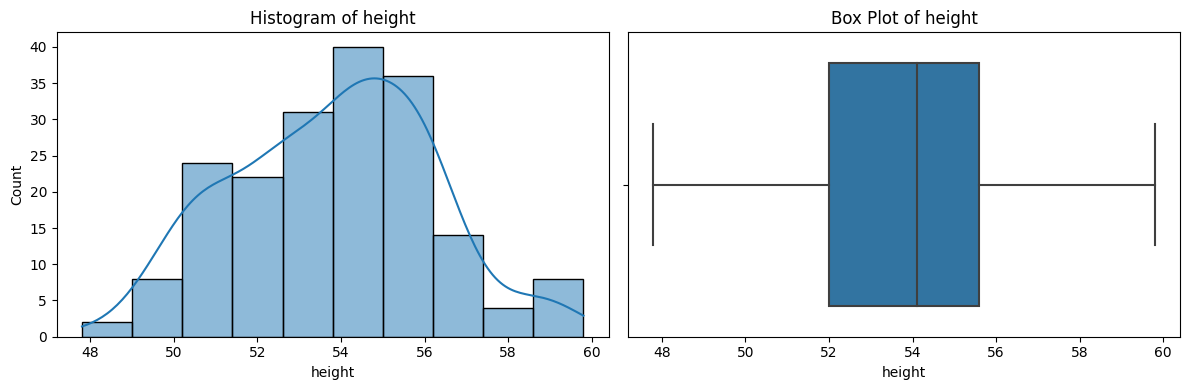

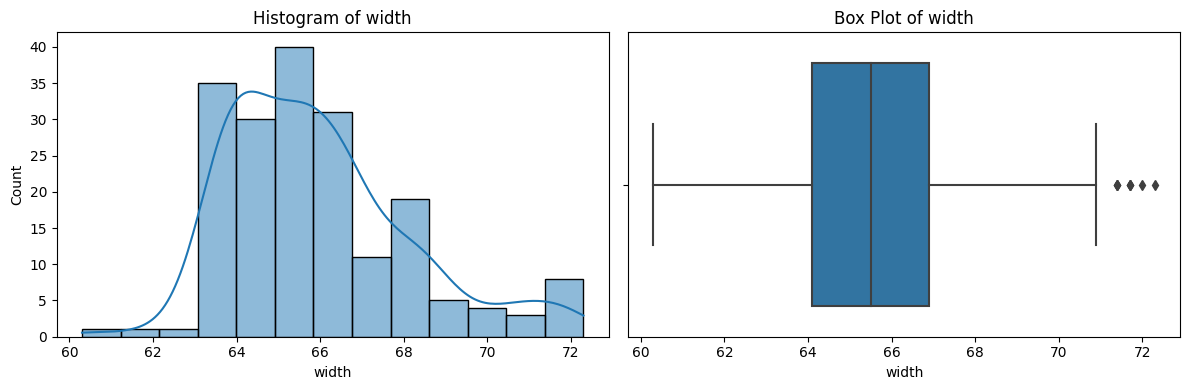

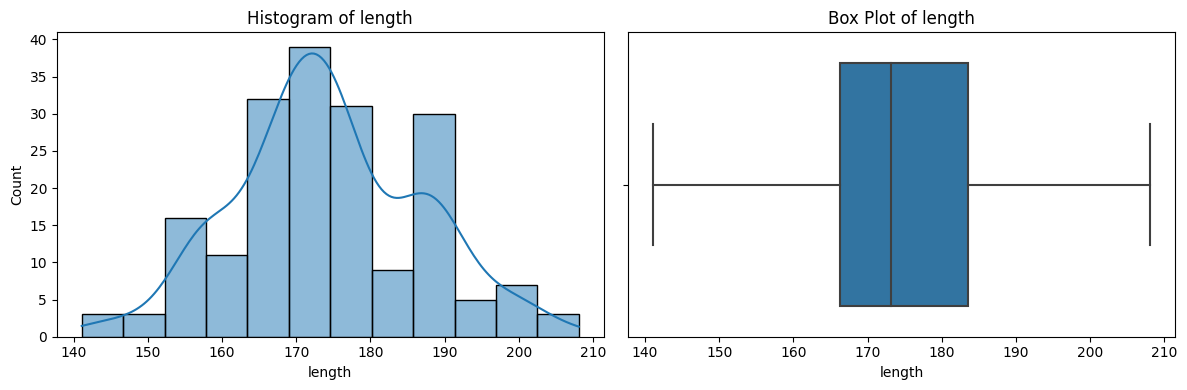

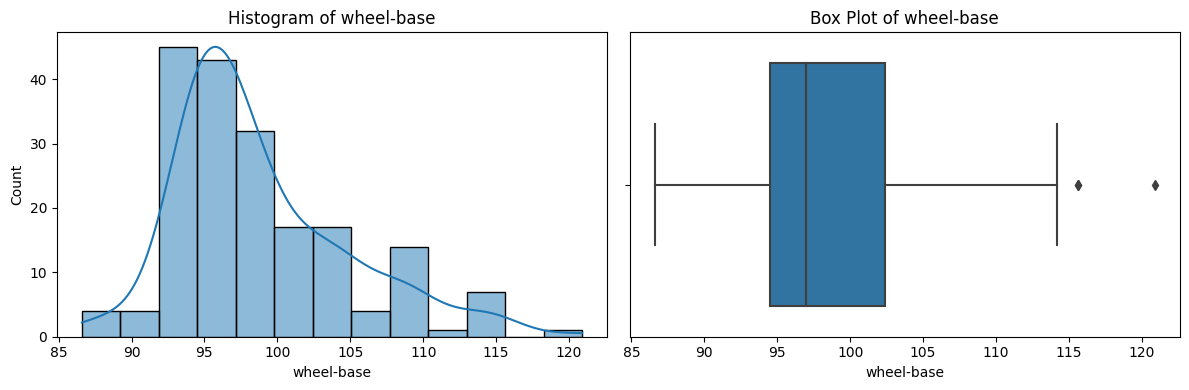

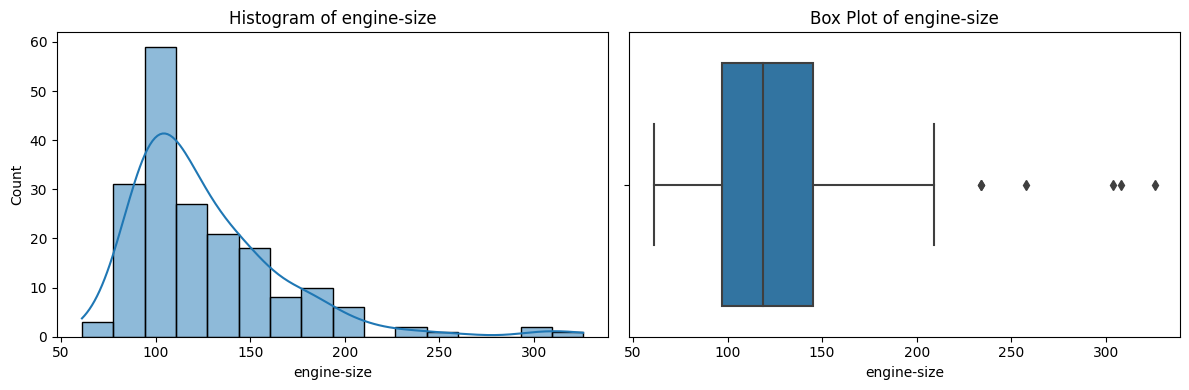

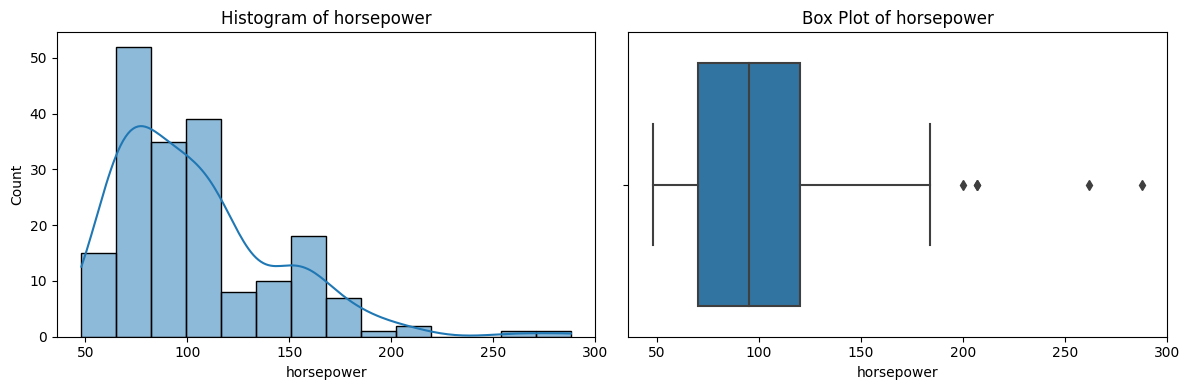

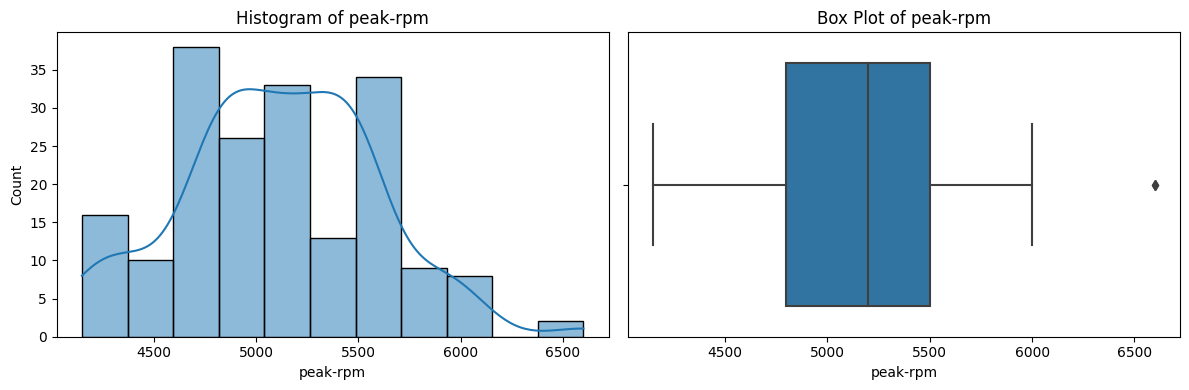

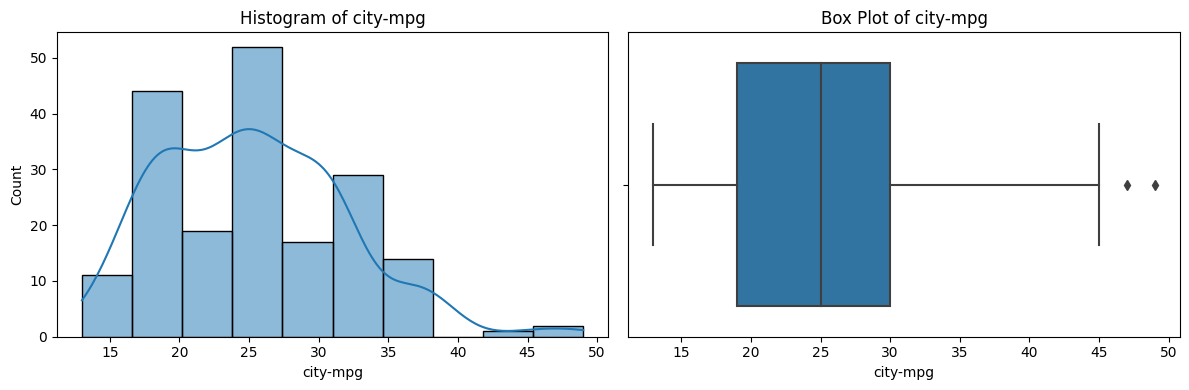

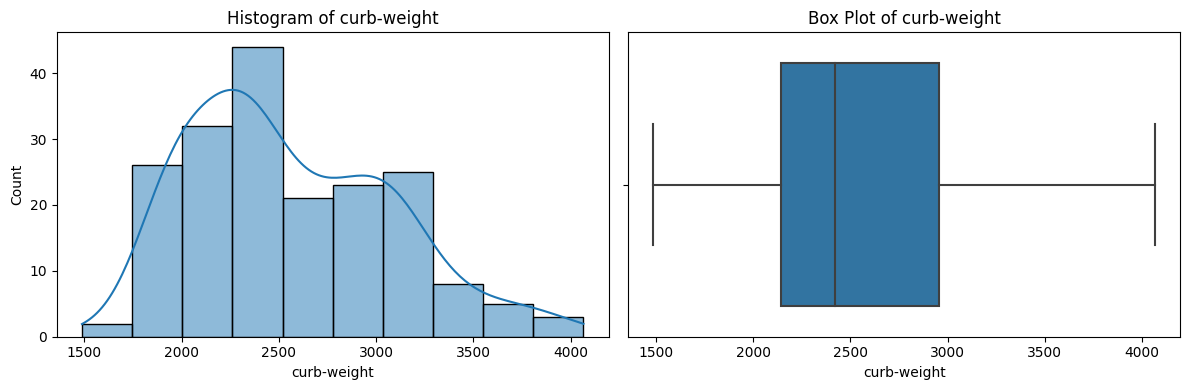

In [12]:
Hist_BoxPlotFunction(automobile_df,'Quant_visuals.pdf')


1. Except curb-weight, length & height all other columns have outliers, that too minimum.
2. On looking into city-mpg, horse power & engine-size we have efficient vehicles over luxury or high-speed capabilities.


In [13]:
####### I am using correlation matrix for identifying independent columns to dependent columns

def plot_correlation_matrix(df):

    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    plt.show()


In [ ]:
plot_correlation_matrix(automobile_df)

Based on the above correlation matrix curb-weight is mostly correlated with width, length, engine-size, wheel-base & city-mpg, technically also makes sense.

# Feature Selection

We are removing height & peak-rpm columns for modelling as they are less correlated to curb-weight (Target attribute)

Multicollinearity occurs when independent variables in a regression model are highly correlated, we can use most corelated variable

Based on Muticollinearity & highly corelated columns we choosed the columns width, length, wheel-base, engine-size, city-mpg for modelling.

Modelling: We are planning to use OLS (Ordinary Least Squares) & Ridge regression

In [ ]:
######### Split the data into Train, Test 

X = automobile_df[['width','length','wheel-base','engine-size','city-mpg']]

y = automobile_df[['curb-weight']]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of X_train & X_test: ",X_train.shape, X_test.shape)
print("Shape of y_train & y_test: ",y_train.shape, y_test.shape)

# Normalize the data

In [ ]:
### Normalize the data (to have all values on same measure)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Linear Regression

In [ ]:
# Create a linear regression object
linear_R = LinearRegression()
linear_R

In [ ]:
# Train the model using the training sets
linear_R.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = linear_R.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_R.coef_)

# Intercept
print('Intercept: \n', linear_R.intercept_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# The mean obsolute error
print('Mean obsolute error: %.2f' % mean_absolute_error(y_test, y_pred))

# The squared mean squared error
print('squared mean squared error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))


# The coefficient of determination: 1 is perfect prediction
print('R2 Score: %.2f' % r2_score(y_test, y_pred))

# Ridge Regression

In [ ]:
# Create a Ridge Regression object
Ridge_R = Ridge(alpha=1.0)
Ridge_R

In [ ]:
# Train the model using the training sets
Ridge_R.fit(X_train, y_train)

# Make predictions using the testing set
Ridge_y_pred = Ridge_R.predict(X_test)

# The coefficients
print('Coefficients: \n', Ridge_R.coef_)

# Intercept
print('Intercept: \n', Ridge_R.intercept_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, Ridge_y_pred))

# The mean obsolute error
print('Mean obsolute error: %.2f' % mean_absolute_error(y_test, Ridge_y_pred))

# The squared mean squared error
print('squared mean squared error: %.2f' % np.sqrt(mean_squared_error(y_test, Ridge_y_pred)))


# The coefficient of determination: 1 is perfect prediction
print('R2 Score: %.2f' % r2_score(y_test, Ridge_y_pred))

# Cross Validation

In [ ]:
# Define the K-Fold Cross-Validation method
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression model with Cross-Validation
linear_scores = cross_val_score(linear_R, X, y, cv=kfold, scoring='r2')

# Average R2 score for Linear Regression
average_linear_score = np.mean(linear_scores)
print(f'Average R2 Score for Linear Regression: {average_linear_score:.2f}')

In [ ]:
# Ridge Regression model with Cross-Validation
Ridge_scores = cross_val_score(Ridge_R, X, y, cv=kfold, scoring='r2')

# Average R2 score for Ridge Regression
average_ridge_score = np.mean(Ridge_scores)
print(f'Average R2 Score for Ridge Regression: {average_ridge_score:.2f}')

Conclusion: The code successfully applies 5-Fold Cross-Validation to Linear and Ridge Regression models, providing a robust comparison of their performances with average R2 scores. 